In [1]:
import numpy as np
import matplotlib.pyplot as plt
import fitsio
import sys, os, glob
from astropy.table import Table

from main_def import cut_sweeps

import warnings; warnings.simplefilter('ignore')
#sys.path.insert(0, '/global/homes/q/qmxp55/DESI/matches/quality_cuts/')
#from extract_bgs import _prepare_optical_wise, _psflike

## Loading DR8C SWEEPS

Loading DECAM SWEEPS from Adam M. custom copy that includes `BRIGHTBLOB` and `MASKBITS` here: `/global/cscratch1/sd/adamyers/dr8c-custom-sweeps/`

Details at e-mail: `[desi-targets 2278] Re: [decam-data 3437] Minutes from DECaLS/MzLS call, 1 May 2019`

In [2]:
dr8c_path = '/global/cscratch1/sd/adamyers/dr8c-custom-sweeps/decam/sweep'
dr8c_files = sorted(glob.glob(os.path.join(dr8c_path, '*.fits')))
df8c = cut_sweeps(130, 150, 30, 40, sweep_dir=dr8c_path, rlimit=20)

sweep-130p030-140p035 with 81730 objects out of 1453957 at rmag=20
sweep-130p035-140p040 with 132 objects out of 1294 at rmag=20
sweep-140p030-150p035 with 3392 objects out of 61197 at rmag=20
Bricks that matched: 3
Sample region # objects: 85254


In [6]:
df8c_targets_path = '/project/projectdirs/desi/target/catalogs/dr8c/PR490'
df8c_tar = fitsio.read(dr8c_targets_path+'/main/targets-dr8c-PR490.fits', ext=1)
df8c_ran = fitsio.read(dr8c_targets_path+'/randoms-dr8c-PR490.fits', ext=1)

(30, 36)

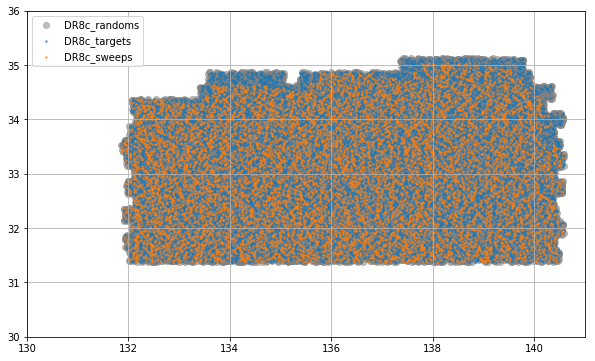

In [17]:
plt.figure(figsize=(10,6))

plt.scatter(df8c_ran['RA'][::100], df8c_ran['DEC'][::100],c='gray', alpha=0.5, label='DR8c_randoms')
plt.scatter(df8c_tar['RA'][::10], df8c_tar['DEC'][::10], alpha=0.7, s=2, label='DR8c_targets')
plt.scatter(df8c['RA'][::10], df8c['DEC'][::10], alpha=0.7, s=2, label='DR8c_sweeps')

plt.legend()
plt.grid()
plt.xlim(130, 141)
plt.ylim(30, 36)

## BGS catalogue

This BGS catalogue includes:
    
        *(G-rr) > 0.6 or (G == 0) star-galaxy separation by GAIA 
        *NOBS_{G,R,Z} > 0
        *FRACMASKED_{G,R,Z} < 0.4
        *FRACIN_{G,R,Z} > 0.3
        *FRACFLUX_{G,R,Z} < 5
        *FLUX_IVAR_{G,R,Z} > 0
        *-1 < g-r < 4
        *-1 < r-z < 4
        

In [31]:
bgs = get_targtype(df8c, 'all')

## BRIGHTBLOB (BB) masking

In [59]:
BB_bright = (np.uint64(df8c['BRIGHTBLOB']) & np.uint64(2**0))!=0
BB_medium = (np.uint64(df8c['BRIGHTBLOB']) & np.uint64(2**1))!=0
BB_cluster = (np.uint64(df8c['BRIGHTBLOB']) & np.uint64(2**2))!=0
BB_galaxy = (np.uint64(df8c['BRIGHTBLOB']) & np.uint64(2**3))!=0
BB = (BB_bright) | (BB_medium) | (BB_cluster) | (BB_galaxy)

BB_list = [BB_bright, BB_medium, BB_cluster, BB_galaxy, BB]
for i in BB_list:
    print(np.sum(i))

3692
13770
0
720
14461


## BITMASK (BM) masking

In [60]:
BM_bright = (np.uint64(df8c['MASKBITS']) & np.uint64(2**1))!=0
BM_medium = (np.uint64(df8c['MASKBITS']) & np.uint64(2**11))!=0
BM_cluster = (np.uint64(df8c['MASKBITS']) & np.uint64(2**13))!=0
BM_galaxy = (np.uint64(df8c['MASKBITS']) & np.uint64(2**12))!=0
BM = (BM_bright) | (BM_medium) | (BM_cluster) | (BM_galaxy)

BM_list = [BM_bright, BM_medium, BM_cluster, BM_galaxy, BM]
for i in BM_list:
    print(np.sum(i))

3694
13777
0
736
14486


## BB Vs BM overlap in BGS

In [78]:
def venn(mask1, mask2, tot, label1, label2, title):
    
    from matplotlib_venn import venn2
    plt.figure(figsize=(5, 5))

    a = mask1
    b = mask2
    c = (mask1) & (mask2)

    A = round((np.sum(a) - np.sum(c))*100/tot, 2)
    B = round((np.sum(b) - np.sum(c))*100/tot, 2)
    C = round((np.sum(c))*100/tot, 2)
    
    plt.title(title, size=15)
    venn2([A, B, C], set_labels = (label1, label2))
    

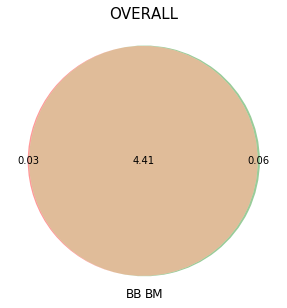

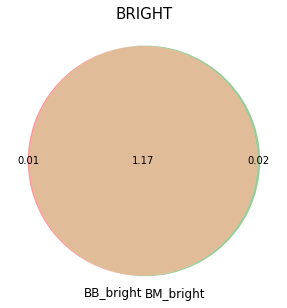

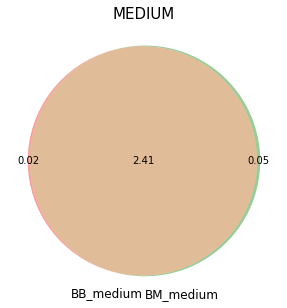

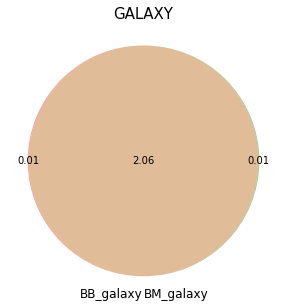

In [80]:
venn(mask1=((BB) & (bgs)), mask2=((BM) & (bgs)), tot=np.sum(bgs), label1='BB', label2='BM', title='OVERALL')

venn(mask1=((BB_bright) & (bgs)), mask2=((BM_bright) & (bgs)), tot=np.sum(bgs), label1='BB_bright', label2='BM_bright', title='BRIGHT')

venn(mask1=((BB_medium) & (bgs)), mask2=((BM_medium) & (bgs)), tot=np.sum(bgs), label1='BB_medium', label2='BM_medium', title='MEDIUM')

venn(mask1=((BB_galaxy) & (bgs)), mask2=((BM_galaxy) & (bgs)), tot=np.sum(bgs), label1='BB_galaxy', label2='BM_galaxy', title='GALAXY')

# DEFINITIONS...

In [25]:
def flux_to_mag(flux):
    mag = 22.5 - 2.5*np.log10(flux)
    return mag

In [26]:
def isBGS(gflux=None, rflux=None, zflux=None, w1flux=None, w2flux=None, rfiberflux=None,
          gnobs=None, rnobs=None, znobs=None, gfracmasked=None, rfracmasked=None, zfracmasked=None,
          gfracflux=None, rfracflux=None, zfracflux=None, gfracin=None, rfracin=None, zfracin=None,
          gfluxivar=None, rfluxivar=None, zfluxivar=None, Grr=None,
          w1snr=None, gaiagmag=None, objtype=None, primary=None, south=True, targtype=None):
    """Definition of BGS target classes. Returns a boolean array.

    Parameters
    ----------
    south : :class:`boolean`, defaults to ``True``
        Use cuts appropriate to the Northern imaging surveys (BASS/MzLS) if ``south=False``,
        otherwise use cuts appropriate to the Southern imaging survey (DECaLS).
    targtype : :class:`str`, optional, defaults to ``faint``
        Pass ``bright`` to use colors appropriate to the ``BGS_BRIGHT`` selection
        or ``faint`` to use colors appropriate to the ``BGS_FAINT`` selection
        or ``faint_ext`` to use colors appropriate to the ``BGS_FAINT_EXTENDED`` selection
	or ``lowq`` to use colors appropriate to the ``BGS_LOW_QUALITY`` selection
	or ``fibmag`` to use colors appropriate to the ``BGS_FIBER_MAGNITUDE`` selection.

    Returns
    -------
    :class:`array_like`
        ``True`` if and only if the object is a BGS target of type ``targtype``.

    Notes
    -----
    - Current version (11/05/18) is version 24 on `the SV wiki`_.
    - See :func:`~desitarget.sv1.sv1_cuts.set_target_bits` for other parameters.
    """
    #_check_BGS_targtype_sv(targtype)

    # ------ Bright Galaxy Survey
    if primary is None:
        primary = np.ones_like(rflux, dtype='?')
    bgs = primary.copy()

    bgs &= notinBGS_mask(gflux=gflux, rflux=rflux, zflux=zflux, gnobs=gnobs, rnobs=rnobs, znobs=znobs, primary=primary,
                         gfracmasked=gfracmasked, rfracmasked=rfracmasked, zfracmasked=zfracmasked,
                         gfracflux=gfracflux, rfracflux=rfracflux, zfracflux=zfracflux,
                         gfracin=gfracin, rfracin=rfracin, zfracin=zfracin, w1snr=w1snr,
                         gfluxivar=gfluxivar, rfluxivar=rfluxivar, zfluxivar=zfluxivar, Grr=Grr,
                         gaiagmag=gaiagmag, objtype=objtype, targtype=targtype)
    

    bgs &= isBGS_colors(rflux=rflux, rfiberflux=rfiberflux, south=south, targtype=targtype, primary=primary)
        
    return bgs 


def notinBGS_mask(gflux=None, rflux=None, zflux=None, gnobs=None, rnobs=None, znobs=None, primary=None,
                  gfracmasked=None, rfracmasked=None, zfracmasked=None,
                  gfracflux=None, rfracflux=None, zfracflux=None,
                  gfracin=None, rfracin=None, zfracin=None, w1snr=None,
                  gfluxivar=None, rfluxivar=None, zfluxivar=None, Grr=None,
                  gaiagmag=None, objtype=None, targtype=None):
    """Standard set of masking cuts used by all BGS target selection classes
    (see, e.g., :func:`~desitarget.cuts.isBGS_faint` for parameters).
    """
    #_check_BGS_targtype_sv(targtype)

    if primary is None:
        primary = np.ones_like(gnobs, dtype='?')
    bgs_qcs = primary.copy()
    bgs = primary.copy()

    # quality cuts definitions
    bgs_qcs &= (gnobs >= 1) & (rnobs >= 1) & (znobs >= 1)
    bgs_qcs &= (gfracmasked < 0.4) & (rfracmasked < 0.4) & (zfracmasked < 0.4)
    bgs_qcs &= (gfracflux < 5.0) & (rfracflux < 5.0) & (zfracflux < 5.0)
    bgs_qcs &= (gfracin > 0.3) & (rfracin > 0.3) & (zfracin > 0.3)
    bgs_qcs &= (gfluxivar > 0) & (rfluxivar > 0) & (zfluxivar > 0)
    #bgs_qcs &= ~brightstarinblob
    
    bgs_qcs &= rflux > gflux * 10**(-1.0/2.5)
    bgs_qcs &= rflux < gflux * 10**(4.0/2.5)
    bgs_qcs &= zflux > rflux * 10**(-1.0/2.5)
    bgs_qcs &= zflux < rflux * 10**(4.0/2.5)
    
    if targtype == 'lowq':
        bgs &= Grr > 0.6
        bgs |= gaiagmag == 0
        bgs |= (Grr < 0.6) & (~_psflike(objtype)) & (gaiagmag != 0)
        print('PSF STARS: %i' %(np.sum((Grr < 0.6) & (~_psflike(objtype)) & (gaiagmag != 0))))
        bgs &= ~bgs_qcs
    else:
        bgs &= Grr > 0.6
        bgs |= gaiagmag == 0
        #bgs |= (Grr < 0.6) & (~_psflike(objtype)) & (gaiagmag != 0)
        #print('PSF STARS: %i' %(np.sum((Grr < 0.6) & (~_psflike(objtype)) & (gaiagmag != 0))))
        #print('objects that arent galaxies:', np.sum(~bgs))
        bgs &= bgs_qcs

    return bgs


def isBGS_colors(rflux=None, rfiberflux=None, south=True, targtype=None, primary=None):
    """Standard set of masking cuts used by all BGS target selection classes
    (see, e.g., :func:`~desitarget.cuts.isBGS` for parameters).
    """

    if primary is None:
        primary = np.ones_like(rflux, dtype='?')
    bgs = primary.copy()

    if targtype == 'lowq':
        bgs &= rflux > 10**((22.5-21.0)/2.5)
    elif targtype == 'bright':
        bgs &= rflux > 10**((22.5-19.5)/2.5)
        #bgs &= bgs_gr_rz
    elif targtype == 'faint':
        bgs &= rflux > 10**((22.5-20.1)/2.5)
        bgs &= rflux <= 10**((22.5-19.5)/2.5)
        #bgs &= bgs_gr_rz
    elif targtype == 'faint_ext':
        bgs &= rflux > 10**((22.5-20.5)/2.5)
        bgs &= rflux <= 10**((22.5-20.1)/2.5)
        #bgs &= bgs_gr_rz
    elif targtype == 'fibmag':
        bgs &= rflux <= 10**((22.5-20.1)/2.5)
        bgs &= rfiberflux > 10**((22.5-21.0511)/2.5)
        #bgs &= bgs_gr_rz
    elif targtype == 'all':
        bgs &= rflux > 10**((22.5-20.0)/2.5)

    return bgs 


In [27]:
def get_targtype(CAT, tarty):
    
    (obs_rflux, gflux, rflux, zflux,
            w1flux, w2flux, rfiberflux, objtype, release, gfluxivar, rfluxivar, zfluxivar,
            gnobs, rnobs, znobs, gfracflux, rfracflux, zfracflux,
            gfracmasked, rfracmasked, zfracmasked,
            gfracin, rfracin, zfracin, gallmask, rallmask, zallmask,
            gsnr, rsnr, zsnr, w1snr, w2snr, dchisq, deltaChi2, gaiagmag,
            Grr) = _prepare_optical_wise(CAT)
    
    BGS = isBGS(gflux=gflux, rflux=rflux, zflux=zflux, w1flux=w1flux, w2flux=w2flux,
                    rfiberflux=rfiberflux, gnobs=gnobs, rnobs=rnobs, znobs=znobs,
                    gfracmasked=gfracmasked, rfracmasked=rfracmasked, zfracmasked=zfracmasked,
                    gfracflux=gfracflux, rfracflux=rfracflux, zfracflux=zfracflux,
                    gfracin=gfracin, rfracin=rfracin, zfracin=zfracin,
                    gfluxivar=gfluxivar, rfluxivar=rfluxivar, zfluxivar=zfluxivar,
                    Grr=Grr, w1snr=w1snr, gaiagmag=gaiagmag,
                    objtype=objtype, primary=None, south=True, targtype=tarty)
    
    return BGS

In [28]:
def _prepare_optical_wise(objects, colnames=None):
    """Process the Legacy Surveys inputs for target selection."""

    if colnames is None:
        colnames = _get_colnames(objects)

    obs_rflux = objects['FLUX_R']

    # - undo Milky Way extinction
    flux = unextinct_fluxes(objects)

    gflux = flux['GFLUX']
    rflux = flux['RFLUX']
    zflux = flux['ZFLUX']
    w1flux = flux['W1FLUX']
    w2flux = flux['W2FLUX']
    rfiberflux = flux['RFIBERFLUX']
    objtype = objects['TYPE']
    release = objects['RELEASE']

    gfluxivar = objects['FLUX_IVAR_G']
    rfluxivar = objects['FLUX_IVAR_R']
    zfluxivar = objects['FLUX_IVAR_Z']

    gnobs = objects['NOBS_G']
    rnobs = objects['NOBS_R']
    znobs = objects['NOBS_Z']

    gfracflux = objects['FRACFLUX_G']
    rfracflux = objects['FRACFLUX_R']
    zfracflux = objects['FRACFLUX_Z']

    gfracmasked = objects['FRACMASKED_G']
    rfracmasked = objects['FRACMASKED_R']
    zfracmasked = objects['FRACMASKED_Z']

    gfracin = objects['FRACIN_G']
    rfracin = objects['FRACIN_R']
    zfracin = objects['FRACIN_Z']

    gallmask = objects['ALLMASK_G']
    rallmask = objects['ALLMASK_R']
    zallmask = objects['ALLMASK_Z']

    gsnr = objects['FLUX_G'] * np.sqrt(objects['FLUX_IVAR_G'])
    rsnr = objects['FLUX_R'] * np.sqrt(objects['FLUX_IVAR_R'])
    zsnr = objects['FLUX_Z'] * np.sqrt(objects['FLUX_IVAR_Z'])
    w1snr = objects['FLUX_W1'] * np.sqrt(objects['FLUX_IVAR_W1'])
    w2snr = objects['FLUX_W2'] * np.sqrt(objects['FLUX_IVAR_W2'])

    # For BGS target selection
    #brightstarinblob = objects['BRIGHTSTARINBLOB']
    
    gaiagmag = objects['GAIA_PHOT_G_MEAN_MAG']
    # For BGS target selection
    Grr = gaiagmag - 22.5 + 2.5*np.log10(objects['FLUX_R'])

    # Delta chi2 between PSF and SIMP morphologies; note the sign....
    dchisq = objects['DCHISQ']
    deltaChi2 = dchisq[..., 0] - dchisq[..., 1]

    # ADM remove handful of NaN values from DCHISQ values and make them unselectable
    w = np.where(deltaChi2 != deltaChi2)
    # ADM this is to catch the single-object case for unit tests
    if len(w[0]) > 0:
        deltaChi2[w] = -1e6

    return (obs_rflux, gflux, rflux, zflux,
            w1flux, w2flux, rfiberflux, objtype, release, gfluxivar, rfluxivar, zfluxivar,
            gnobs, rnobs, znobs, gfracflux, rfracflux, zfracflux,
            gfracmasked, rfracmasked, zfracmasked,
            gfracin, rfracin, zfracin, gallmask, rallmask, zallmask,
            gsnr, rsnr, zsnr, w1snr, w2snr, dchisq, deltaChi2, gaiagmag, Grr)

In [29]:
def _get_colnames(objects):
    """Simple wrapper to get the column names."""

    # ADM capture the case that a single FITS_REC is passed
    import astropy.io.fits.fitsrec
    if isinstance(objects, astropy.io.fits.fitsrec.FITS_record):
        colnames = objects.__dict__['array'].dtype.names
    else:
        colnames = objects.dtype.names

    return colnames

In [30]:
def unextinct_fluxes(objects):
    """Calculate unextincted DECam and WISE fluxes.

    Args:
        objects: array or Table with columns FLUX_G, FLUX_R, FLUX_Z,
            MW_TRANSMISSION_G, MW_TRANSMISSION_R, MW_TRANSMISSION_Z,
            FLUX_W1, FLUX_W2, MW_TRANSMISSION_W1, MW_TRANSMISSION_W2

    Returns:
        array or Table with columns GFLUX, RFLUX, ZFLUX, W1FLUX, W2FLUX

    Output type is Table if input is Table, otherwise numpy structured array
    """
    dtype = [('GFLUX', 'f4'), ('RFLUX', 'f4'), ('ZFLUX', 'f4'),
             ('W1FLUX', 'f4'), ('W2FLUX', 'f4'), ('RFIBERFLUX', 'f4')]
    if _is_row(objects):
        result = np.zeros(1, dtype=dtype)[0]
    else:
        result = np.zeros(len(objects), dtype=dtype)

    result['GFLUX'] = objects['FLUX_G'] / objects['MW_TRANSMISSION_G']
    result['RFLUX'] = objects['FLUX_R'] / objects['MW_TRANSMISSION_R']
    result['ZFLUX'] = objects['FLUX_Z'] / objects['MW_TRANSMISSION_Z']
    result['W1FLUX'] = objects['FLUX_W1'] / objects['MW_TRANSMISSION_W1']
    result['W2FLUX'] = objects['FLUX_W2'] / objects['MW_TRANSMISSION_W2']
    result['RFIBERFLUX'] = objects['FIBERFLUX_R'] / objects['MW_TRANSMISSION_R']

    if isinstance(objects, Table):
        return Table(result)
    else:
        return result
    

def _psflike(psftype):
    """ If the object is PSF """
    # ADM explicitly checking for NoneType. I can't see why we'd ever want to
    # ADM run this test on empty information. In the past we have had bugs where
    # ADM we forgot to pass objtype=objtype in, e.g., isSTD
    if psftype is None:
        raise ValueError("NoneType submitted to _psfflike function")

    psftype = np.asarray(psftype)
    # ADM in Python3 these string literals become byte-like
    # ADM so to retain Python2 compatibility we need to check
    # ADM against both bytes and unicode
    # ADM, also 'PSF' for astropy.io.fits; 'PSF ' for fitsio (sigh)
    psflike = ((psftype == 'PSF') | (psftype == b'PSF') |
               (psftype == 'PSF ') | (psftype == b'PSF '))
    return psflike

def _is_row(table):
    """Return True/False if this is a row of a table instead of a full table.
    supports numpy.ndarray, astropy.io.fits.FITS_rec, and astropy.table.Table
    """
    import astropy.io.fits.fitsrec
    import astropy.table.row
    if isinstance(table, (astropy.io.fits.fitsrec.FITS_record, astropy.table.row.Row)) or \
       np.isscalar(table):
        return True
    else:
        return False